## Instalação de Dependências

In [ ]:
!pip -q install opencv-python numpy matplotlib

## Importações

In [ ]:
import os, time
import cv2
import numpy as np
from dataclasses import dataclass
from typing import Tuple, List, Optional
from matplotlib import pyplot as plt

## Configuration de Hiperparâmetros

In [ ]:
@dataclass
class CFG:
    cfg_path: str = "yolov3-tiny.cfg"
    weights_path: str = "yolov3-tiny.weights"
    names_path: str = "coco.names"
    target_class: str = "person"

    use_clahe: bool = True
    clahe_clip: float = 2.0
    clahe_grid: Tuple[int, int] = (8, 8)

    inp_size_default: int = 416
    conf_default: float = 0.30
    nms_default: float = 0.30

    min_box_area: int = 800
    vertical_overlap_threshold: float = 0.5
    horizontal_distance_threshold: int = 50

    input_sizes: Tuple[int, ...] = (320, 416, 512)
    conf_candidates: Tuple[float, ...] = (0.25, 0.30, 0.35, 0.40)
    nms_candidates: Tuple[float, ...] = (0.25, 0.30, 0.35)

CFG_ = CFG()
print("Configuração inicializada")

Configuração inicializada


## Download YOLO

In [ ]:
if not os.path.exists(CFG_.cfg_path):
    !wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3-tiny.cfg

if not os.path.exists(CFG_.weights_path):
    !wget -q https://pjreddie.com/media/files/yolov3-tiny.weights

if not os.path.exists(CFG_.names_path):
    !wget -q https://raw.githubusercontent.com/pjreddie/darknet/master/data/coco.names

print("Arquivos YOLO disponíveis")

Arquivos YOLO disponíveis


## Funções

In [ ]:
# Classe pessoas

def get_classes(names_path: str) -> List[str]:
    """Carrega nomes das classes do COCO"""
    with open(names_path, "r") as f:
        return [c.strip() for c in f.readlines()]

CLASSES = get_classes(CFG_.names_path)
PERSON_ID = CLASSES.index(CFG_.target_class)
print(f"Classes carregadas. ID 'person': {PERSON_ID}")

Classes carregadas. ID 'person': 0


In [ ]:
# Pré-processamento

def apply_clahe_bgr(img_bgr: np.ndarray, clip_limit: float = 2.0, grid=(8, 8)) -> np.ndarray:
    """Aplica equalização adaptativa de histograma (CLAHE) para melhorar contraste"""
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid)
    l2 = clahe.apply(l)
    lab2 = cv2.merge([l2, a, b])
    return cv2.cvtColor(lab2, cv2.COLOR_LAB2BGR)

def letterbox(image_bgr: np.ndarray, new_size: int) -> Tuple[np.ndarray, float, int, int]:
    """Redimensiona imagem mantendo aspect ratio com padding"""
    h, w = image_bgr.shape[:2]
    scale = min(new_size / w, new_size / h)
    nw, nh = int(round(w * scale)), int(round(h * scale))
    resized = cv2.resize(image_bgr, (nw, nh), interpolation=cv2.INTER_LINEAR)
    canvas = np.full((new_size, new_size, 3), 128, dtype=np.uint8)
    pad_x = (new_size - nw) // 2
    pad_y = (new_size - nh) // 2
    canvas[pad_y:pad_y + nh, pad_x:pad_x + nw] = resized
    return canvas, scale, pad_x, pad_y

print("Funções de pré-processamento carregadas")

Funções de pré-processamento carregadas


In [ ]:
# Cluster e Merge

def compute_vertical_overlap(box1: Tuple[int, int, int, int], box2: Tuple[int, int, int, int]) -> float:
    """Calcula overlap vertical normalizado entre duas boxes"""
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2

    y1_min, y1_max = y1, y1 + h1
    y2_min, y2_max = y2, y2 + h2

    inter_y = max(0, min(y1_max, y2_max) - max(y1_min, y2_min))
    min_height = min(h1, h2)

    return inter_y / min_height if min_height > 0 else 0.0

def horizontal_distance(box1: Tuple[int, int, int, int], box2: Tuple[int, int, int, int]) -> float:
    """
    Calcula distância horizontal entre centros de duas boxes
    Agrupa boxes que representam a mesma pessoa:
    - Overlap vertical > threshold
    - Centros horizontalmente próximos
    - Mantém box de maior confiança por cluster

    """
    x1, y1, w1, h1 = box1
    x2, y2, w2, h2 = box2
    center1_x = x1 + w1 / 2
    center2_x = x2 + w2 / 2
    return abs(center1_x - center2_x)

def cluster_and_merge_boxes(
    boxes: List[List[int]],
    confidences: List[float],
    vertical_overlap_thresh: float = 0.5,
    horizontal_dist_thresh: int = 50
) -> List[List[int]]:

    if len(boxes) == 0:
        return []

    n = len(boxes)
    merged = [False] * n
    clusters = []

    sorted_idx = sorted(range(n), key=lambda i: confidences[i], reverse=True)

    for i in sorted_idx:
        if merged[i]:
            continue

        cluster_boxes = [boxes[i]]
        cluster_confs = [confidences[i]]
        merged[i] = True

        for j in range(n):
            if merged[j] or i == j:
                continue

            v_overlap = compute_vertical_overlap(boxes[i], boxes[j])
            h_dist = horizontal_distance(boxes[i], boxes[j])

            if v_overlap > vertical_overlap_thresh and h_dist < horizontal_dist_thresh:
                cluster_boxes.append(boxes[j])
                cluster_confs.append(confidences[j])
                merged[j] = True

        best_idx = cluster_confs.index(max(cluster_confs))
        clusters.append(cluster_boxes[best_idx])

    return clusters

print("Função de clustering carregada")

print("Funções de geometria carregadas")

Função de clustering carregada
Funções de geometria carregadas


## Carregando o Modelo

In [ ]:
def load_yolo(cfg_path: str, weights_path: str):
    """Carrega YOLOv3-tiny com backend CUDA se disponível"""
    net = cv2.dnn.readNetFromDarknet(cfg_path, weights_path)

    cuda_ok = False
    try:
        cuda_ok = (hasattr(cv2, "cuda") and cv2.cuda.getCudaEnabledDeviceCount() > 0)
    except:
        cuda_ok = False

    if cuda_ok:
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA_FP16)
        print("penCV DNN usando CUDA FP16")
    else:
        net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
        net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)
        print("OpenCV DNN usando CPU")

    layer_names = net.getLayerNames()
    out_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers().flatten()]
    return net, out_layers

net, out_layers = load_yolo(CFG_.cfg_path, CFG_.weights_path)

OpenCV DNN usando CPU


## Warmup do Modelo

In [ ]:
_dummy = np.zeros((CFG_.inp_size_default, CFG_.inp_size_default, 3), dtype=np.uint8)
blob = cv2.dnn.blobFromImage(_dummy, 1/255.0, (CFG_.inp_size_default, CFG_.inp_size_default), swapRB=True, crop=False)
net.setInput(blob)
_ = net.forward(out_layers)
print("Warmup completo")

Warmup completo


## Função de Inferência

In [ ]:
def infer_people(
    image_bgr: np.ndarray,
    net,
    out_layers: List[str],
    person_id: int,
    conf_threshold: float,
    nms_threshold: float,
    inp_size: int,
    min_area: int = 800,
    vertical_overlap_thresh: float = 0.5,
    horizontal_dist_thresh: int = 50
) -> Tuple[int, np.ndarray, float]:
    """
    Detecta pessoas em uma imagem com eliminação de duplicatas.

    Returns:
        count: número de pessoas detectadas
        vis_image: imagem com detecções desenhadas
        infer_ms: tempo de inferência em ms
    """
    H, W = image_bgr.shape[:2]
    img_lb, scale, pad_x, pad_y = letterbox(image_bgr, inp_size)

    blob = cv2.dnn.blobFromImage(
        img_lb, scalefactor=1/255.0, size=(inp_size, inp_size),
        swapRB=True, crop=False
    )
    net.setInput(blob)

    t0 = time.perf_counter()
    outs = net.forward(out_layers)
    infer_ms = (time.perf_counter() - t0) * 1000.0

    boxes: List[List[int]] = []
    confidences: List[float] = []

    for out in outs:
        for det in out:
            obj = float(det[4])
            if obj <= 0:
                continue

            scores = det[5:]
            cid = int(np.argmax(scores))
            class_prob = float(scores[cid])
            conf = obj * class_prob

            if cid != person_id or conf < conf_threshold:
                continue

            cx, cy, w, h = det[0:4]

            x_lb = (cx - w/2) * inp_size
            y_lb = (cy - h/2) * inp_size
            w_lb = w * inp_size
            h_lb = h * inp_size

            x = (x_lb - pad_x) / scale
            y = (y_lb - pad_y) / scale
            ww = w_lb / scale
            hh = h_lb / scale

            x1 = int(np.clip(x, 0, W - 1))
            y1 = int(np.clip(y, 0, H - 1))
            x2 = int(np.clip(x + ww, 0, W))
            y2 = int(np.clip(y + hh, 0, H))

            ww_i = max(1, x2 - x1)
            hh_i = max(1, y2 - y1)

            if ww_i * hh_i < min_area:
                continue

            boxes.append([x1, y1, ww_i, hh_i])
            confidences.append(conf)

    if len(boxes) == 0:
        return 0, image_bgr.copy(), infer_ms

    idxs = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    if len(idxs) == 0:
        return 0, image_bgr.copy(), infer_ms

    filtered_boxes = [boxes[i] for i in idxs.flatten()]
    filtered_confs = [confidences[i] for i in idxs.flatten()]

    final_boxes = cluster_and_merge_boxes(
        filtered_boxes, filtered_confs,
        vertical_overlap_thresh, horizontal_dist_thresh
    )

    vis = image_bgr.copy()
    for idx, (x, y, ww, hh) in enumerate(final_boxes, 1):
        cv2.rectangle(vis, (x, y), (x + ww, y + hh), (0, 255, 0), 3)
        cv2.putText(vis, f"#{idx}", (x, max(20, y - 8)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    return len(final_boxes), vis, infer_ms

print("Função de inferência carregada")

Função de inferência carregada


## Sweep de Hiperparâmetros

In [ ]:
def sweep_configs(
    image_bgr: np.ndarray,
    net,
    out_layers: List[str],
    person_id: int,
    input_sizes: Tuple[int, ...],
    conf_candidates: Tuple[float, ...],
    nms_candidates: Tuple[float, ...],
    min_area: int,
    vertical_overlap_thresh: float,
    horizontal_dist_thresh: int
) -> List[Tuple[int, float, float, float, int]]:
    """
    Testa diferentes combinações de hiperparâmetros.
    Retorna lista ordenada por máximo de detecções.
    """
    results = []
    total_combos = len(input_sizes) * len(conf_candidates) * len(nms_candidates)

    print(f"🔍 Testando {total_combos} combinações...\n")

    for size in input_sizes:
        for conf in conf_candidates:
            for nms in nms_candidates:
                c, _, ms = infer_people(
                    image_bgr, net, out_layers, person_id,
                    conf_threshold=conf,
                    nms_threshold=nms,
                    inp_size=size,
                    min_area=min_area,
                    vertical_overlap_thresh=vertical_overlap_thresh,
                    horizontal_dist_thresh=horizontal_dist_thresh
                )
                results.append((c, ms, conf, nms, size))

    results.sort(key=lambda x: (-x[0], x[1]))
    return results

print("Função de sweep carregada")

Função de sweep carregada


## Upload da Imagem

In [ ]:
from google.colab import files

uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

img_bgr = cv2.imread(img_path)
if img_bgr is None:
    raise ValueError


img_infer = apply_clahe_bgr(img_bgr, CFG_.clahe_clip, CFG_.clahe_grid) if CFG_.use_clahe else img_bgr
print(f"Imagem carregada: {img_path}")

Saving person.png to person.png
Imagem carregada: person.png


## Execução com Sweep de Hiperparâmetros

In [ ]:
DO_SWEEP = True

if DO_SWEEP:
    print("\n" + "="*70)
    print("SWEEP DE HIPERPARÂMETROS")
    print("="*70 + "\n")

    results = sweep_configs(
        img_infer, net, out_layers, PERSON_ID,
        CFG_.input_sizes, CFG_.conf_candidates, CFG_.nms_candidates,
        CFG_.min_box_area, CFG_.vertical_overlap_threshold,
        CFG_.horizontal_distance_threshold
    )

    print("\n Top 10 configurações (ordenado por max detecções):\n")
    print(f"{'Count':<8} {'Infer(ms)':<12} {'Conf':<8} {'NMS':<8} {'Size':<8}")
    print("="*60)
    for (c, ms, conf, nms, size) in results[:10]:
        print(f"{c:<8} {ms:<12.1f} {conf:<8.2f} {nms:<8.2f} {size:<8}")

    best_count, best_ms, best_conf, best_nms, best_size = results[0]
    print(f"\n Melhor config: count={best_count}, conf={best_conf}, nms={best_nms}, size={best_size}")
else:
    best_conf = CFG_.conf_default
    best_nms = CFG_.nms_default
    best_size = CFG_.inp_size_default
    print("\nUsando configuração padrão (sweep desabilitado)")


SWEEP DE HIPERPARÂMETROS

🔍 Testando 36 combinações...


 Top 10 configurações (ordenado por max detecções):

Count    Infer(ms)    Conf     NMS      Size    
6        62.0         0.25     0.35     320     
6        65.4         0.25     0.30     320     
6        98.6         0.25     0.35     416     
6        99.5         0.25     0.30     416     
6        132.5        0.25     0.25     320     
6        317.8        0.25     0.25     416     
5        62.5         0.35     0.25     320     
5        63.0         0.30     0.30     320     
5        64.1         0.30     0.35     320     
5        64.4         0.30     0.25     320     

 Melhor config: count=6, conf=0.25, nms=0.35, size=320


## Detecção Final


RESULTADO FINAL
DETECÇÕES: 6 pessoas
Inferência: 185.5 ms
Parâmetros: conf=0.25 | nms=0.35 | size=320
CLAHE: Ativado


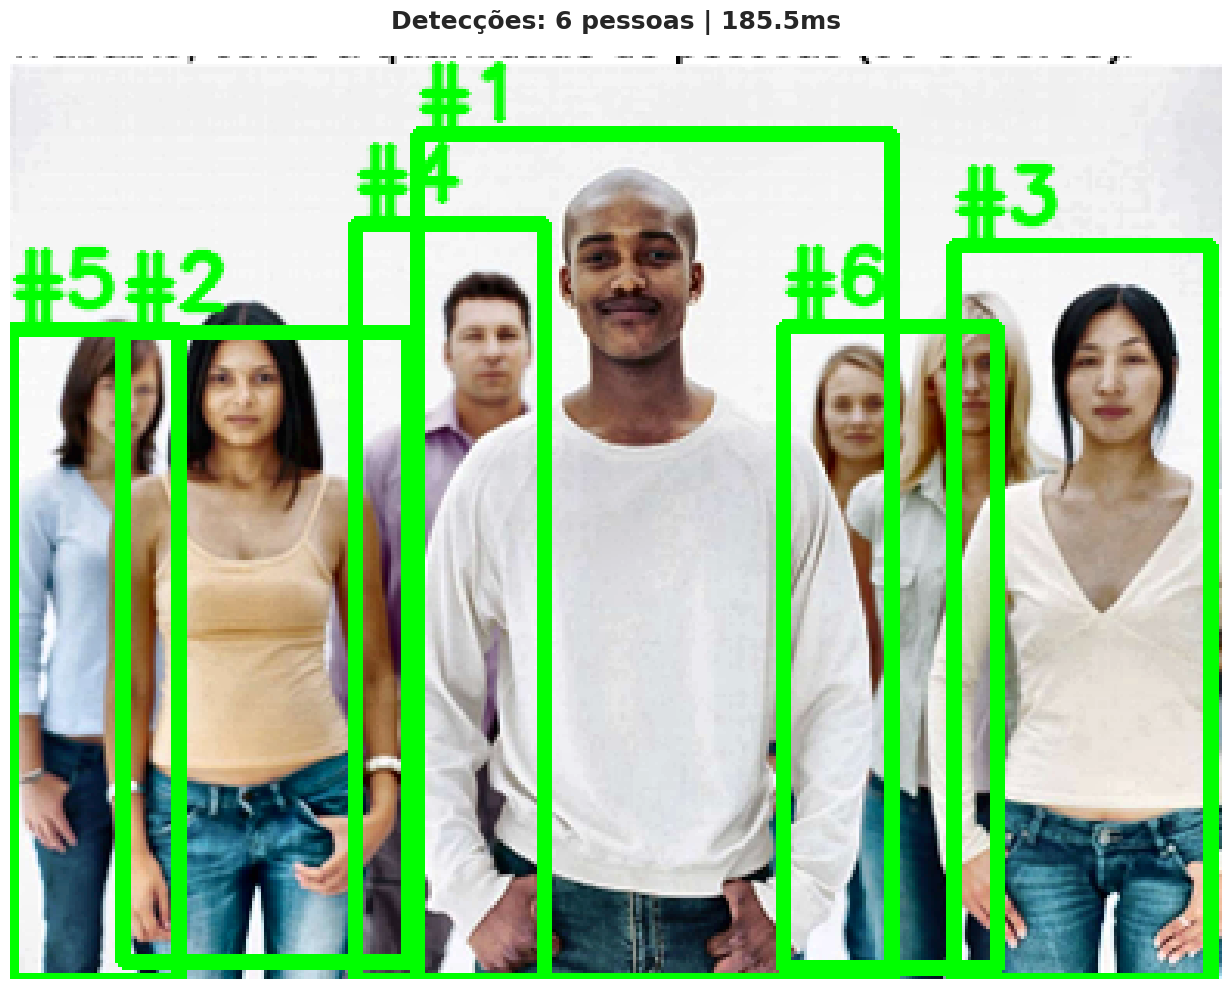

In [ ]:
count, vis_bgr, infer_ms = infer_people(
    img_infer, net, out_layers, PERSON_ID,
    conf_threshold=best_conf,
    nms_threshold=best_nms,
    inp_size=best_size,
    min_area=CFG_.min_box_area,
    vertical_overlap_thresh=CFG_.vertical_overlap_threshold,
    horizontal_dist_thresh=CFG_.horizontal_distance_threshold
)

print("\n" + "="*70)
print("RESULTADO FINAL")
print("="*70)
print(f"DETECÇÕES: {count} pessoas")
print(f"Inferência: {infer_ms:.1f} ms")
print(f"Parâmetros: conf={best_conf} | nms={best_nms} | size={best_size}")
print(f"CLAHE: {'Ativado' if CFG_.use_clahe else 'Desativado'}")
print("="*70)


vis_rgb = cv2.cvtColor(vis_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(16, 10))
plt.imshow(vis_rgb)
plt.title(f"Detecções: {count} pessoas | {infer_ms:.1f}ms", fontsize=18, weight='bold', pad=20)
plt.axis('off')
plt.tight_layout()
plt.show()

## Salvar Resultado

In [ ]:
output_path = "resultado_deteccao.jpg"
cv2.imwrite(output_path, vis_bgr)
print(f"✅ Resultado salvo em: {output_path}")

files.download(output_path)

✅ Resultado salvo em: resultado_deteccao.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>